In [ ]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Machine learning
# Title: Antarctic glacier analysis
# Contributors: Kimm Soo Min
# Last modified date: 14/05/25

In [29]:
# Library
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import *
from torchmetrics import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


In [3]:
print(os.getcwd())

/Users/somnio.kimm/Library/CloudStorage/GoogleDrive-somnio.kimm@gmail.com/My Drive/Class/ESTSOFT/project/antarctic_glacier_analysis/code


In [14]:
# Import data
df = pd.read_csv('../data/input/ice_extent/S_extent_merged.csv')
df.set_index('date', inplace=True)

In [15]:
# Handle missing values
df.loc["1987-12-01"] = df.loc["1986-12-01"]
df.loc["1988-01-01"] = df.loc["1987-01-01"]

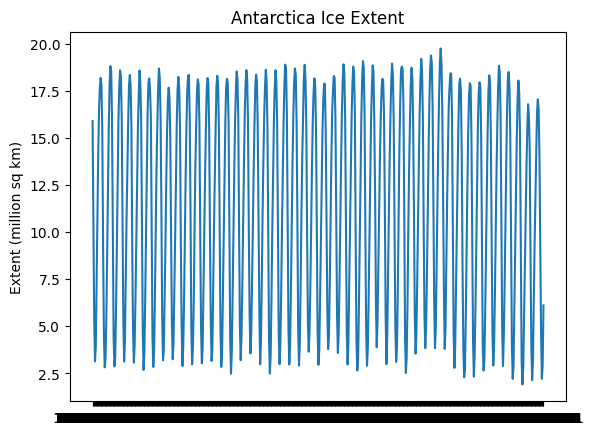

In [16]:
# Plot data
# plt.figure(figsize=(40, 8))
plt.plot(df.index, df['extent'])
plt.ylabel("Extent (million sq km)")
plt.title("Antarctica Ice Extent")
plt.show()

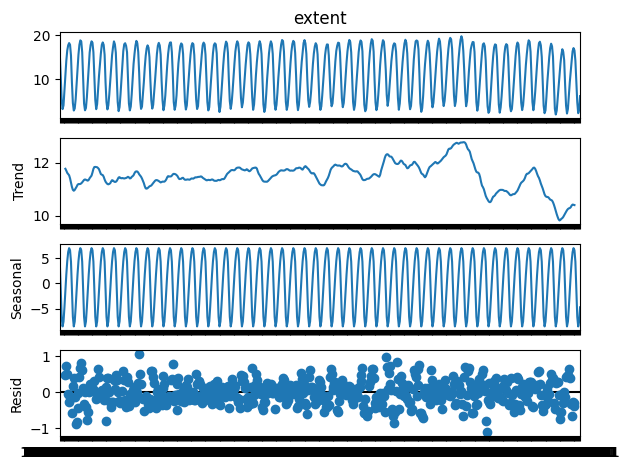

In [20]:
decomp = sm.tsa.seasonal_decompose(df['extent'], model='additive', period=12)
decomp.plot()
plt.show()

In [21]:
# ADF w/o differencing
adf_wo_diff = adfuller(df['extent'])
print(f'ADF Statistic: {adf_wo_diff[0]} | p-value: {adf_wo_diff[1]}')

ADF Statistic: -3.0290859892503406 | p-value: 0.03226597595626949


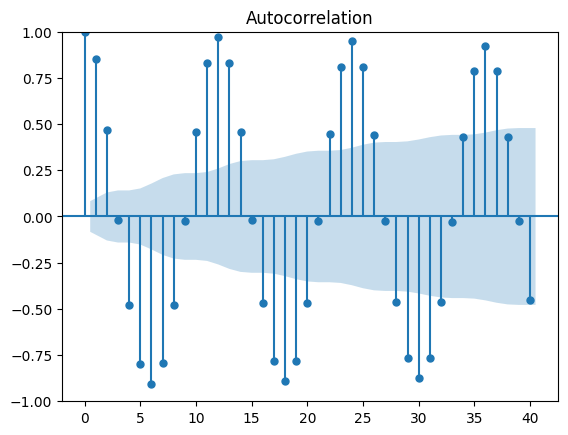

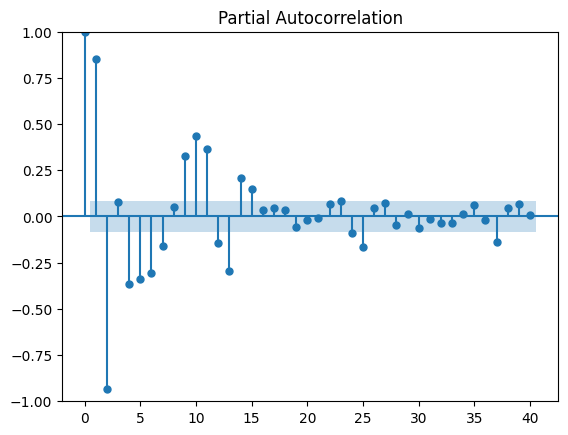

In [24]:
# ACF & PACF w/o differencing
plot_acf(df['extent'], lags=40)
plt.show()
plot_pacf(df['extent'], lags=40)
plt.show()

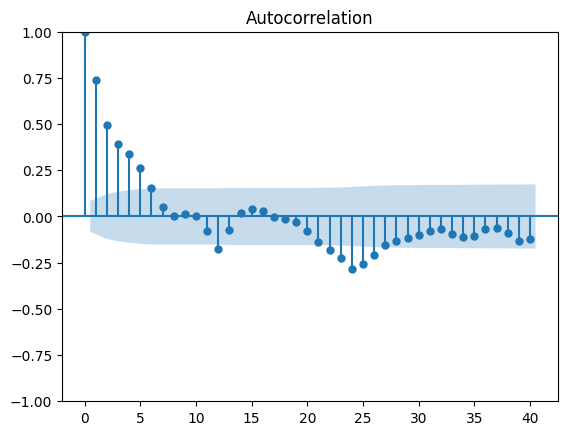

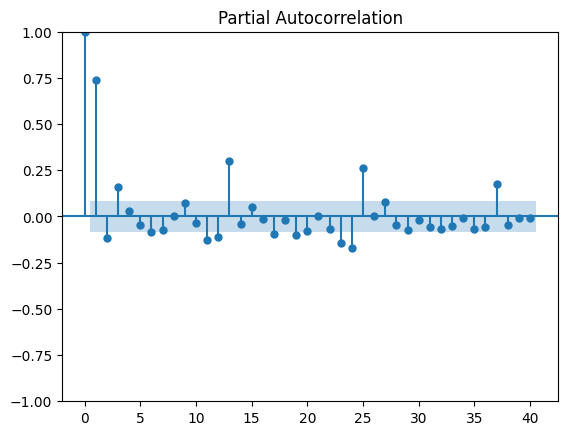

In [ ]:
# # ACF & PACF w/ differencing
df['seasonal_diff'] = df['extent'] - df['extent'].shift(12)
plot_acf(df['seasonal_diff'].dropna(), lags=40)
plt.show()
plot_pacf(df['seasonal_diff'].dropna(), lags=40)
plt.show()

In [ ]:
# Data split
df_train = df[0 : int(len(df) * 0.8)]
df_test = df[int(len(df) * 0.8) :]


In [32]:
# AIC
model_sarima = auto_arima(df_train['extent'],
						  seasonal=True,
						  m=12,
						  start_p=0, max_p=2,
						  start_q=0, max_q=2,
						  start_P=0, max_P=1,
						  start_Q=0, max_Q=1,
						  d=1, D=1,
						  stepwise=True,
						  trace=True,
						  suppress_warnings=True,
						  error_action='ignore')

/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=578.765, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=520.009, Time=0.17 sec


/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=579.068, Time=0.03 sec


/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.55 sec


/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=519.035, Time=0.07 sec


/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.45 sec


/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=519.045, Time=0.12 sec


/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.96 sec


/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=521.023, Time=0.21 sec

Best model:  ARIMA(0,1,0)(1,1,0)[12]          
Total fit time: 4.359 seconds


In [34]:
# SARIMAX
model_sarimax = SARIMAX(df_train['extent'],
						order=model_sarima.order,
						seasonal_order=model_sarima.seasonal_order,
						enforce_stationarity=False,
						enforce_invertibility=False)
result_sarimax = model_sarimax.fit()
print(result_sarimax.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48307D-01    |proj g|=  5.20985D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   5.237D-05   5.483D-01
  F =  0.54830728883019353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                             extent   No. Observations:                  446
Model:      

/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/somnio.kimm/.pyenv/versions/3.10.13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
